<a href="https://colab.research.google.com/github/idrisaltamimi/basira-app/blob/main/GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 243346528/243346528 [03:11<00:00, 1269161.40it/s]


Extracting data/lfw-py/lfw-funneled.tgz to data/lfw-py


100%|██████████| 66403/66403 [00:00<00:00, 428350.53it/s]


100%|██████████| 94727/94727 [00:00<00:00, 410016.98it/s]


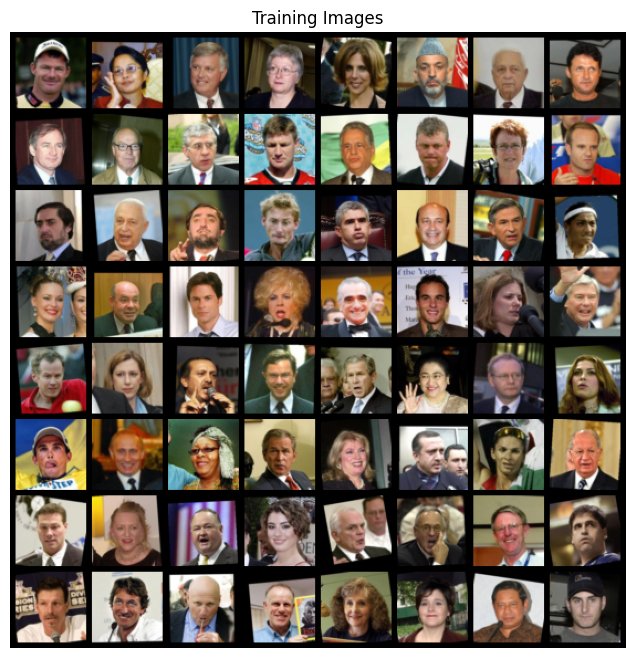

Total samples: 9525
Iterations per epoch: 149


In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
import numpy as np
import matplotlib.pyplot as plt

torch.autograd.set_detect_anomaly(True)


dataset = datasets.LFWPeople(root="data",
                              split='train',
                              download = True,
                              transform = transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                              )

dataloader = data.DataLoader(dataset, batch_size=64,shuffle=True, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Plot some training images

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()


# Total number of samples in the dataset
total_samples = len(dataset)

# Batch size
batch_size = 64

# Calculating the number of iterations per epoch
iterations_per_epoch = (total_samples + batch_size - 1) // batch_size  # Use integer division

print(f'Total samples: {total_samples}')
print(f'Iterations per epoch: {iterations_per_epoch}')



In [2]:

class Generator(nn.Module):
  def __init__(self, laten_space, channel_num, output_channels):
    super(Generator, self).__init__()
    self.channel_num = channel_num
    self.output_channels = output_channels
    self.laten_space = laten_space

    self.generator = nn.Sequential(
        nn.ConvTranspose2d(self.laten_space      , self.output_channels*8, 3, 1, 0, bias=False), nn.BatchNorm2d(self.output_channels*8), nn.ReLU(),   # -> (3,3,512)
        nn.ConvTranspose2d(self.output_channels*8, self.output_channels*4, 3, 2, 1, bias=False), nn.BatchNorm2d(self.output_channels*4), nn.ReLU(),   # -> (5,5,256)
        nn.ConvTranspose2d(self.output_channels*4, self.output_channels*2, 3, 2, 1, bias=False), nn.BatchNorm2d(self.output_channels*2), nn.ReLU(),   # -> (9,9,128)
        nn.ConvTranspose2d(self.output_channels*2, self.output_channels*2, 3, 2, 1, bias=False), nn.BatchNorm2d(self.output_channels*2  ), nn.ReLU(), # -> (17,17,128)
        nn.ConvTranspose2d(self.output_channels*2, self.output_channels*2, 3, 1, 1, bias=False), nn.BatchNorm2d(self.output_channels*2  ), nn.ReLU(), # -> (17,17,128)
        nn.ConvTranspose2d(self.output_channels*2, self.output_channels*2, 3, 1, 1, bias=False), nn.BatchNorm2d(self.output_channels*2  ), nn.ReLU(), # -> (17,17,128)
        nn.ConvTranspose2d(self.output_channels*2, self.output_channels  , 3, 2, 1, bias=False), nn.BatchNorm2d(self.output_channels  ), nn.ReLU(),   # -> (33,33,64)
        nn.ConvTranspose2d(self.output_channels  , self.channel_num      , 3, 2, 2, 1,bias=False),                                                    # -> (64,64,3)
        nn.Tanh()
    )


  def forward(self,x):
      return self.generator(x)




class Discriminator(nn.Module):
    def __init__ (self, channel_num, output_channels):
        super(Discriminator, self).__init__()
        self.channel_num = channel_num
        self.output_channels = output_channels
        self.discriminator = nn.Sequential(
          nn.Conv2d(self.channel_num,       self.output_channels   , 5, 1, 2, bias=False),  nn.LeakyReLU(0.2,  inplace=False),                                                 # -> (64,64, 64)
          nn.Conv2d(self.output_channels,    self.output_channels   , 5, 1, 2, bias=False),  nn.BatchNorm2d(self.output_channels), nn.LeakyReLU(0.2,  inplace=False),          # -> (64,64, 64)
          nn.Conv2d(self.output_channels,    self.output_channels   , 4, 2, 1, bias=False),  nn.BatchNorm2d(self.output_channels),nn.LeakyReLU(0.2,  inplace=False),           # -> (32,32, 64)
          nn.Conv2d(self.output_channels,   self.output_channels *2, 4, 2, 1, bias=False),  nn.BatchNorm2d(self.output_channels*2), nn.LeakyReLU(0.2,  inplace=False),         # -> (16,16, 128)
          nn.Conv2d(self.output_channels*2, self.output_channels *4, 4, 2, 1, bias=False),  nn.BatchNorm2d(self.output_channels*4), nn.LeakyReLU(0.2, inplace=False),          # -> (8,8, 256)
          nn.Conv2d(self.output_channels*4, self.output_channels *8, 4, 2, 1, bias=False),  nn.BatchNorm2d(self.output_channels*8), nn.LeakyReLU(0.2, inplace=False),          # -> (4,4, 512)
          nn.Conv2d(self.output_channels*8, self.output_channels *8, 4, 2, 1, bias=False),  nn.BatchNorm2d(self.output_channels*8), nn.LeakyReLU(0.2, inplace=False),          # -> (2,2, 512)
          nn.Conv2d(self.output_channels*8,                       1, 2, 1, 0, bias=False),                                                                                     # -> (1,1, 1)
          nn.Sigmoid()

      )

    def forward(self, x):
        return self.discriminator(x)


netG = Generator(1000, 3, 64).to(device)
netD = Discriminator(3, 64).to(device)


print(netG)
print(netD)

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(1000, 512, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=T

In [ ]:
# Binary Cross Entropy
bce = nn.BCELoss()

optimiserD = optim.Adam(netD.parameters(), lr= 0.001)
optimiserG = optim.Adam(netG.parameters(), lr= 0.001)

fixed_noise = torch.randn(64, 1000, 1, 1, device=device)

epochs = 100
for epoch in range(epochs):
    print(epoch)
    netD.train()
    netG.train()
    for i,(data, _) in enumerate(dataloader):
        netD.zero_grad()
        # Handling real data
        data = data.to(device)
        b_size = data.size(0)
        label = torch.ones(b_size).to(device)
        output = netD(data).view(-1)
        errD_real = bce(output, label)
        D_x = output.mean().item()
        errD_real.backward()

        # Handling fake data
        noise = torch.randn(b_size, 1000, 1, 1, device=device)

        fake = netG(noise)
        label.fill_(0.)
        output = netD(fake.detach()).view(-1)
        errD_fake = bce(output, label)
        errD_fake.backward()
        optimiserD.step()

        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake


        netG.zero_grad()
        # Update Generator
        label.fill_(1.)
        output = netD(fake).view(-1)
        errG = bce(output, label)
        D_G_z2 = output.mean().item()
        errG.backward()
        optimiserG.step()


        if i % 20 == 0:
          print(f'[{epoch}/{epochs}][{i}/{len(dataloader)}]\tLoss_D: {errD_fake.item():.4f}\tLoss_G: {errG.item():.4f}\tD(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')


torch.save(netG.state_dict(), "G")
torch.save(netD.state_dict(), "D")

0
[0/100][0/149]	Loss_D: 0.6070	Loss_G: 7.5767	D(x): 0.4886	D(G(z)): 0.4457 / 0.0012
[0/100][20/149]	Loss_D: 0.0377	Loss_G: 4.6821	D(x): 0.9180	D(G(z)): 0.0368 / 0.0104
[0/100][40/149]	Loss_D: 0.0338	Loss_G: 5.8186	D(x): 0.9666	D(G(z)): 0.0326 / 0.0064
[0/100][60/149]	Loss_D: 0.0268	Loss_G: 4.6013	D(x): 0.9950	D(G(z)): 0.0262 / 0.0236
[0/100][80/149]	Loss_D: 0.0323	Loss_G: 3.9259	D(x): 0.9970	D(G(z)): 0.0317 / 0.0237
[0/100][100/149]	Loss_D: 0.0020	Loss_G: 6.9313	D(x): 0.9895	D(G(z)): 0.0020 / 0.0018
[0/100][120/149]	Loss_D: 0.0260	Loss_G: 4.0554	D(x): 0.9994	D(G(z)): 0.0256 / 0.0183
[0/100][140/149]	Loss_D: 0.0086	Loss_G: 4.7280	D(x): 0.9975	D(G(z)): 0.0086 / 0.0098
1
[1/100][0/149]	Loss_D: 0.0083	Loss_G: 5.7610	D(x): 0.9873	D(G(z)): 0.0082 / 0.0045
[1/100][20/149]	Loss_D: 0.0003	Loss_G: 8.1191	D(x): 0.9941	D(G(z)): 0.0003 / 0.0003
[1/100][40/149]	Loss_D: 0.5251	Loss_G: 4.1434	D(x): 0.9935	D(G(z)): 0.3817 / 0.0185
[1/100][60/149]	Loss_D: 0.0288	Loss_G: 5.4561	D(x): 0.9913	D(G(z)): 0.0

In [ ]:
from torch.utils.data import DataLoader
# Testing
dataset_test = datasets.LFWPeople(root="data",
                              split='test',
                              download = True,
                              transform = transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                              )
dataloader_test = DataLoader(dataset_test, batch_size=1,shuffle=True, num_workers=2)

netG.eval()
pil = transforms.ToPILImage()

for i in range(10):
  fixed_noise = torch.randn(64, 1000, 1, 1, device=device)
  fake = netG(fixed_noise.to(device))

  plt.axis("off")
  plt.title("Fake Images")
  plt.imshow(np.array(fake[0].detach().cpu()).transpose(1,2,0))
  plt.show()

